In [1]:
import os
import ast
import re
from ast import literal_eval
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import netwulf as nw
import networkx as nx
from scipy import stats as st
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx.algorithms.community as nx_comm
import colorsys
import random

In [2]:
# Load the network
df_texts = pd.read_csv('descriptions.csv', sep=';', converters={'properties': literal_eval})
stylized_network, config, G = nw.load("Graph.json")

In [3]:
# Create a dictionary and list in the format used by the functions
def return_set():
    return set()
def return_list():
    return []
properties_dict = defaultdict(return_set)
for dic in df_texts['properties']:
    for el in dic.keys():
        for el1 in dic[el]:
            properties_dict[el].add(el1)
properties_list = []
for prop in df_texts['properties']:
    properties_list.append(prop)

In [4]:
def generate_colors(n):
    # Set the number of color hues to evenly space the colors
    hue_values = [i/n for i in range(n)]
    saturation = 0.5
    value = 0.95

    # Convert the HSV color values to RGB format and store them in a list
    colors = []
    for hue in hue_values:
        r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
        r, g, b = int(r * 255), int(g * 255), int(b * 255)
        colors.append((r, g, b))

    # Shuffle the list to randomize the order of colors
    random.shuffle(colors)

    return colors

def graph_with_grouping(properties_dict, attribute, properties_list, Graph, return_communities=False, return_dict=False):
    """
    Given the dictionay of properties and the property/attribute
    of interest, along with the list of properties ordered by
    node, return the graph with randomised colors.
    If return_communities, it will return a list of lists of
    communities
    :param properties_dict:
    :param attribute:
    :param Graph:
    :return:
    """
    from copy import deepcopy

    Graph = deepcopy(Graph)
    possible_values = properties_dict[attribute]
    colors_avail = generate_colors(len(possible_values))
    color_dict = {key: value for key, value in zip(possible_values, colors_avail)}
    color_dict['None'] = (150, 150, 150)
    color_list = []
    communities = defaultdict(return_list)

    for props, node in zip(properties_list, Graph.nodes):
        # Use the size to set the colour
        
        if attribute in props.keys():
            communities[props[attribute][0]].append(node)
            color = '#%02x%02x%02x' % color_dict[props[attribute][0]]
        else:
#             communities[None].append(node)
            color = '#%02x%02x%02x' % (150, 150, 150)
        color_list.append(color)
        
    # zip it up into a dictionary and set it as node attribute
    dictionaryColor = dict(zip(list(Graph.nodes), color_list))
    nx.set_node_attributes(Graph, dictionaryColor, 'group')
    communities = [val for val in communities.values()]
    if return_dict:
        return Graph, communities, color_dict
    if return_communities:
        return Graph, communities
    return Graph

def graph_with_louvain(Graph, communities, return_dict=False):
    """
    Given the dictionay of properties and the property/attribute
    of interest, along with the list of properties ordered by
    node, return the graph with randomised colors.
    If return_communities, it will return a list of lists of
    communities
    :param properties_dict:
    :param attribute:
    :param Graph:
    :return:
    """
    from copy import deepcopy

    Graph = deepcopy(Graph)
    # possible_values = properties_dict[attribute]
    colors_avail = generate_colors(len(communities))
    color_dict = {}

    for com_set, color in zip(communities, colors_avail):
        for val in com_set:
            color_dict[val] = color

    color_list = []
    for node in Graph.nodes:
        # Use the size to set the colour
        color = '#%02x%02x%02x' % color_dict[node]
        color_list.append(color)

    # zip it up into a dictionary and set it as node attribute
    dictionaryColor = dict(zip(list(Graph.nodes), color_list))
    nx.set_node_attributes(Graph, dictionaryColor, 'group')

    if return_dict:
        return Graph, color_dict
    return Graph

def modularity(G, communities):
    m = G.number_of_edges()
    q = .0
    for c in communities:
        lc = G.subgraph(c).number_of_edges()
        kc = sum(G.degree(n) for n in c)
        q += lc / m - (kc / (2 * m)) ** 2
    return q

The following section creates the clusterings based on each attribute and visualises them using netwulf. We create the legends seperately because some of them are massive

Appearances has modularity: 0.3005900808653643
species has modularity: 0.05355279221802146
droid has modularity: 0.0007572923230413778
Dimensions has modularity: 0.00238099926486032
Weapons has modularity: 0.034859240443184225
Locations has modularity: 0.08993810386473433
Affiliations has modularity: 0.10825834252257929
Gender has modularity: -0.0011822949485401774
Vehicles has modularity: 0.020455917874396136
Creature has modularity: -1.0666089056920815e-05
generic has modularity: -3.2818735559756356e-06
star wars has modularity: -5.5791850451585804e-05
Tool has modularity: -0.0018362082545683679
token has modularity: 8.614918084436019e-05


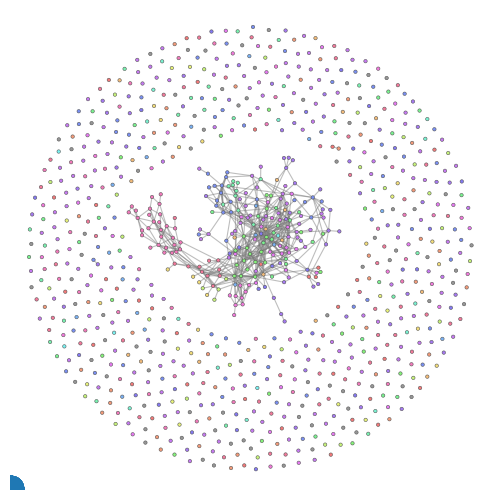

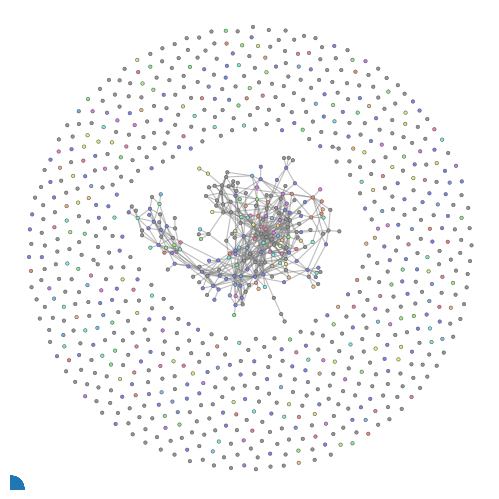

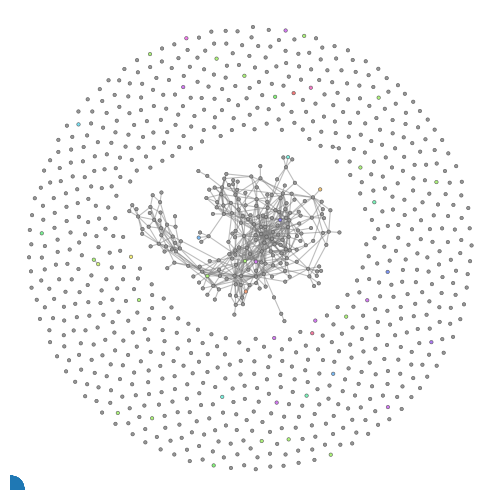

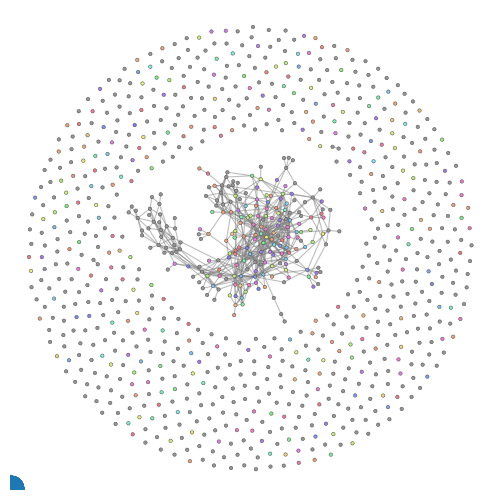

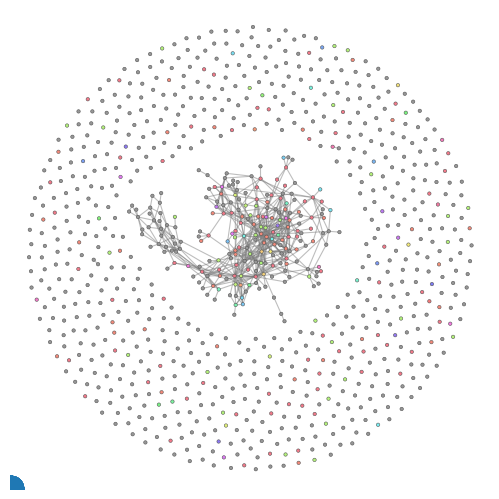

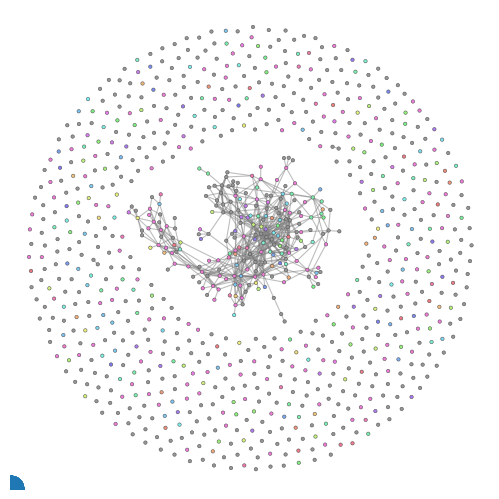

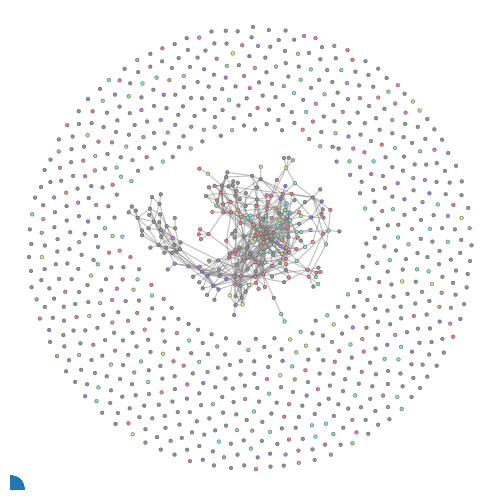

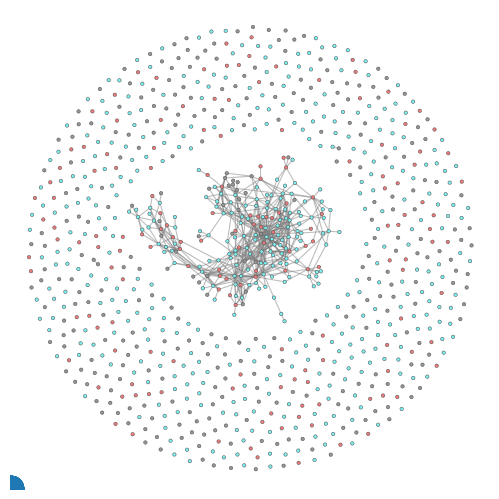

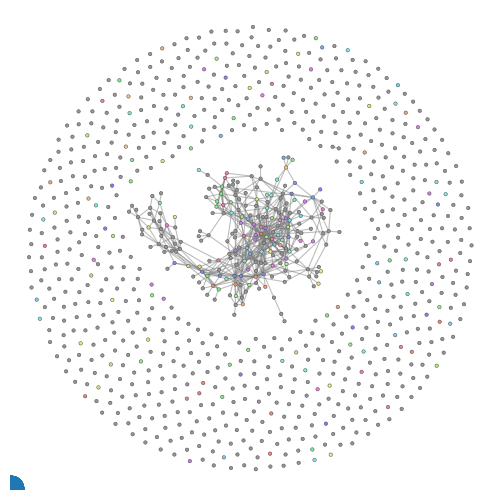

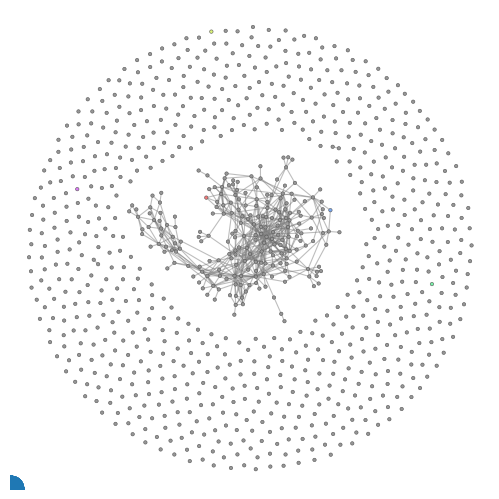

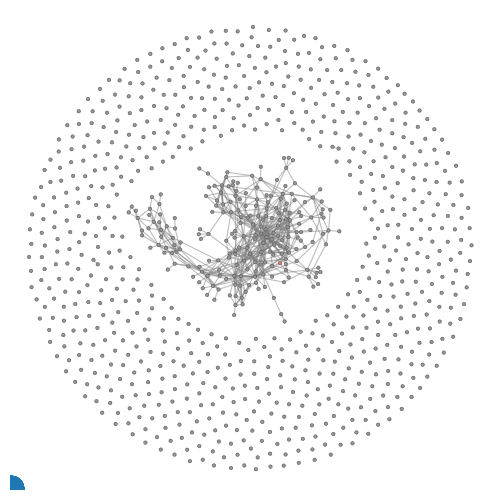

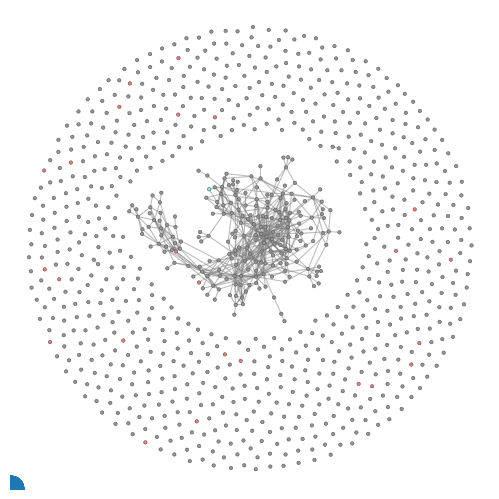

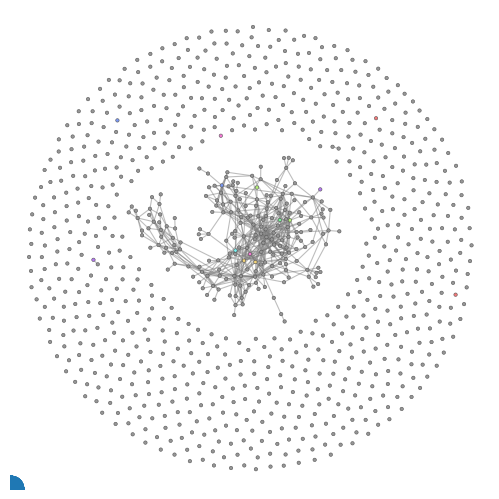

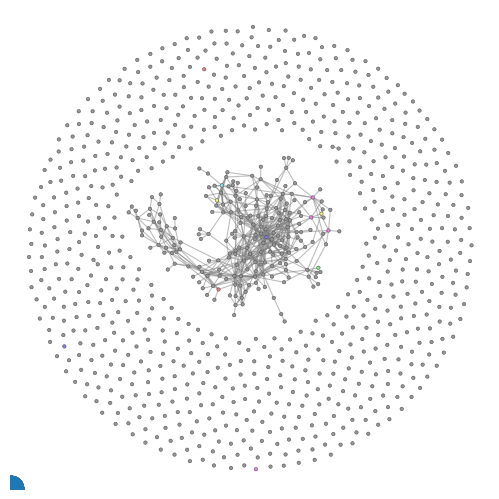

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.patches as mpatches

color_dicts, modularities = [], []
for attribute in properties_dict.keys():
    # Creates the graph with attributes and corresponding colours
    G1, communities, color_dict = graph_with_grouping(properties_dict, attribute, properties_list, G, return_dict=True)
    network, config = nw.visualize(G1, config={'zoom':0.73, 'node charge':-15, 'node gravity': 0.7, 'post to python': True})
    nx.draw(G1)
    # nw.save(f"Graph_{attribute}.json", network, config, G1)
    legendFig = plt.figure("Legend plot")
    handles = [mpatches.Patch(color=np.array(val)/255, label=key) for key, val in color_dict.items()]
    # plt.legend(handles=handles)
    legendFig.legend(handles=handles)
    legendFig.savefig(f'legend_{attribute}.png')
    plt.tight_layout()
    plt.savefig(f"Graph_{attribute}.png")
    modul = modularity(G1, communities)
    print(f"{attribute} has modularity: {modul}")
    # print(color_dict)
    modularities.append(modul)
    color_dicts.append(color_dict)

When looking at the modularities of the different clusterings, the only one above 0.25 is appearances. This is unsurprising as the appearances are a solid explanation for a link. If the two characters appear in the same material there is a high likelihood that they have something to do with each other.

In [6]:
modularities

[0.3005900808653643,
 0.05355279221802146,
 0.0007572923230413778,
 0.00238099926486032,
 0.034859240443184225,
 0.08993810386473433,
 0.10825834252257929,
 -0.0011822949485401774,
 0.020455917874396136,
 -1.0666089056920815e-05,
 -3.2818735559756356e-06,
 -5.5791850451585804e-05,
 -0.0018362082545683679,
 8.614918084436019e-05]

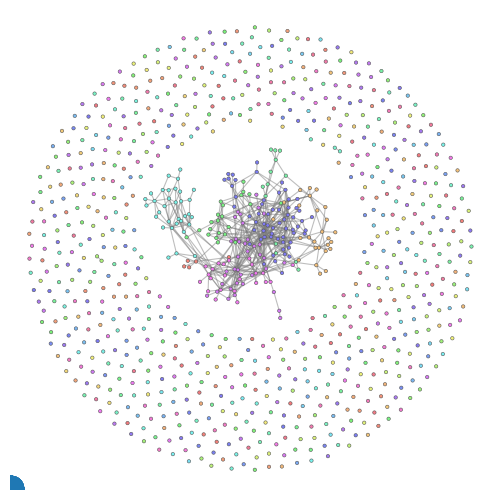

In [8]:
partition = nx_comm.louvain_communities(G)
G1 = graph_with_louvain(G, partition)
network, config = nw.visualize(G1, config={'zoom':0.73, 'node charge':-15, 'node gravity': 0.7, 'post to python': True})
nx.draw(G1)
plt.savefig(f"Graph_louvain.png")
print(f'Louvain groups have modularity {modularity(G1, partition)}')

There is a huge number of nodes that have no links to any other node. This is to be expected due to the nature of characters in the expanded universe of Star Wars. Many characters are introduced in obscure media such as books that few people read, and thus our source does not have much to say about them, leading to no connections.

The bi-directionality of the graph does lead to some loss of information as the nature of the edges is a mention in one article of the other. However, we decided that such a connection should be a between both character as there were so few connections in the entire graph. We did consider using other sources to add nodes to the graph,